In [313]:
# Classification: Can we predict whether a particular car model will be a "best-seller" (yes/no) based on
# features, historical sales data, and marketing efforts.

import pandas as pd
import numpy as np
import os

file_path = "../data/processed/car_sales_data_with_synthetic_features.csv"
df = pd.read_csv(file_path)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Car_id            23906 non-null  object
 1   Date              23906 non-null  object
 2   Customer Name     23905 non-null  object
 3   Gender            23906 non-null  object
 4   Annual Income     23906 non-null  int64 
 5   Dealer_Name       23906 non-null  object
 6   Company           23906 non-null  object
 7   Model             23906 non-null  object
 8   Engine            23906 non-null  object
 9   Transmission      23906 non-null  object
 10  Color             23906 non-null  object
 11  Price ($)         23906 non-null  int64 
 12  Dealer_No         23906 non-null  object
 13  Body Style        23906 non-null  object
 14  Phone             23906 non-null  int64 
 15  Dealer_Region     23906 non-null  object
 16  Mileage_km_total  23906 non-null  int64 
 17  Crash_Test_S

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Mileage_km_total,Crash_Test_Score,Family_Size
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown,68468,4,2
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora,64053,3,2
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville,24942,5,3
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco,108673,3,3
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville,51660,4,1


In [314]:
# Extract year and month from the 'date' column
df["Date"] = pd.to_datetime(df["Date"])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# Combine company and model into a single 'Model' column
df["Full_Model"] = df["Company"] + " " + df["Model"]

# Select relevant features for classification
features = [
    "year",
    "month",
    "Full_Model",
    "Engine",
    "Transmission",
    "Color",
    "Body Style",
    "Mileage_km_total",
    "Crash_Test_Score",
    "Family_Size",
]

df = df[features]

# Rename columns for clarity
df2 = df.rename(
    columns={
        "Full_Model": "full_model",
        "Engine": "engine",
        "Transmission": "transmission",
        "Color": "color",
        "Body Style": "body_style",
        "Mileage_km_total": "mileage_km",
        "Crash_Test_Score": "crash_test_score",
        "Family_Size": "family_size",
    }
)

# Parse types of features
df2 = df2.astype(
    {
        "year": "int",
        "month": "int",
        "crash_test_score": "int",
        "family_size": "int",
        "mileage_km": "int",
    }
)

print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              23906 non-null  int64 
 1   month             23906 non-null  int64 
 2   full_model        23906 non-null  object
 3   engine            23906 non-null  object
 4   transmission      23906 non-null  object
 5   color             23906 non-null  object
 6   body_style        23906 non-null  object
 7   mileage_km        23906 non-null  int64 
 8   crash_test_score  23906 non-null  int64 
 9   family_size       23906 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.8+ MB
None


,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score,family_size
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4,2
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3,2
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5,3
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3,3
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4,1


In [315]:
# Add a new feature to indicate if the car model is a best-seller
# For simplicity, let's assume a model is a best-seller if it is in top 3 models sold in a given year and month.

# Aggregate by year, month, and full_model to get total number of sales
df2_agg = (
    df2.groupby(["year", "month", "full_model"])["year"].count().reset_index(name="total_sales")
)
# Find rank of each full_model within a year and a month based on total_sales
df2_agg["rank"] = df2_agg.groupby(["year", "month"])["total_sales"].rank(method="first", ascending=False)
df2_agg["monthly_best_seller"] = (df2_agg["rank"] <= 3).astype(int)
df2_agg.drop(columns=["rank", "total_sales"], inplace=True)

# Merge the aggregated data back to the original DataFrame
df3 = df2.merge(df2_agg, on=["year", "month", "full_model"], how="left")

df3.head()

,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score,family_size,monthly_best_seller
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4,2,0
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3,2,0
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5,3,1
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3,3,0
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4,1,0


In [316]:
# One-hot encode categorical features
df3 = pd.get_dummies(df3, columns=["full_model", "engine", "transmission", "color", "body_style"], drop_first=True)
df3.head(1)

,year,month,mileage_km,crash_test_score,family_size,monthly_best_seller,full_model_Acura RL,full_model_Acura TL,full_model_Audi A4,full_model_Audi A6,...,full_model_Volvo V40,full_model_Volvo V70,engine_Overhead Camshaft,transmission_Manual,color_Pale White,color_Red,body_style_Hatchback,body_style_Passenger,body_style_SUV,body_style_Sedan
0,2022,1,68468,4,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [317]:
# Prepare data for model training and testing

# from sklearn.model_selection import train_test_split
# X = df3.drop(columns=["monthly_best_seller"])
# y = df3["monthly_best_seller"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

test_cond = (df3["year"] == 2023) & (df3["month"] >= 10)
train_df = df3[~test_cond]
test_df = df3[test_cond]
X_train = train_df.drop(columns=["monthly_best_seller"])
y_train = train_df["monthly_best_seller"]
X_test = test_df.drop(columns=["monthly_best_seller"])
y_test = test_df["monthly_best_seller"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

import numpy as np

dist = np.bincount(y_train)
print("\nClass distribution:", dist)
print("First class:", 100 - dist[1] / dist[0] * 100)
print("Second class:", dist[1] / dist[0] * 100)

Shapes:
(19140, 167) (19140,)
(4766, 167) (4766,)

Class distribution: [17935  1205]
First class: 93.28129356007805
Second class: 6.71870643992194


In [318]:
from sklearn.utils import class_weight

# This tells Keras to penalize misclassifying the minority class more heavily.
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(np.unique(y_train))
print(class_weights_dict)

[0 1]
{0: 0.5335935321996097, 1: 7.941908713692946}


In [319]:
# One-hot encode the target variable for classification
from tensorflow.keras.utils import to_categorical

print(f'Before one-hot encoding: {y_train[0]}')
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f'After one-hot encoding: {y_train[0]}')

Before one-hot encoding: 0
After one-hot encoding: [1. 0.]


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

def build_compile_fit_model(hidden_dim: int, learning_rate: float = 0.001, number_of_hidden_layers: int = 2):
    model = models.Sequential()

    for _ in range(number_of_hidden_layers):
        model.add(layers.Dense(hidden_dim, activation="relu"))
    
    model.add(layers.Dense(2, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",  # Loss function
        optimizer=Adam(learning_rate=learning_rate),  # Optimizer
        metrics=[
            "accuracy",
            # Overall ability to distinguish 0 vs 1. You're comparing models or tuning thresholds.
            metrics.AUC(name="auc"),
            # How often you're right when predicting 1. False alarms (predicting best-seller wrongly) are costly.
            metrics.Precision(name="precision"),
            # How many real best-sellers you catch. You don’t want to miss potential popular models.
            metrics.Recall(name="recall"),
        ],  # Metrics to evaluate the model
    )
    history = model.fit(
        X_train,  # Training data
        y_train,  # Training labels
        epochs=20,  # Number of epochs
        batch_size=32,  # Number of samples per batch
        validation_split=0.1,
        class_weight=class_weights_dict,
    )
    return model, history

In [321]:
model, history = build_compile_fit_model(hidden_dim=128, learning_rate=0.001, number_of_hidden_layers=2)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 128)

In [ ]:
loss, accuracy, auc, precision, recall = model.evaluate(X_test, y_test)

print(f"Loss:     {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0880 - auc: 0.0768 - loss: 5.5212 - precision: 0.0880 - recall: 0.0880
Loss:     5.45
Accuracy: 0.09
AUC: 0.08
Precision: 0.09
Recall: 0.09


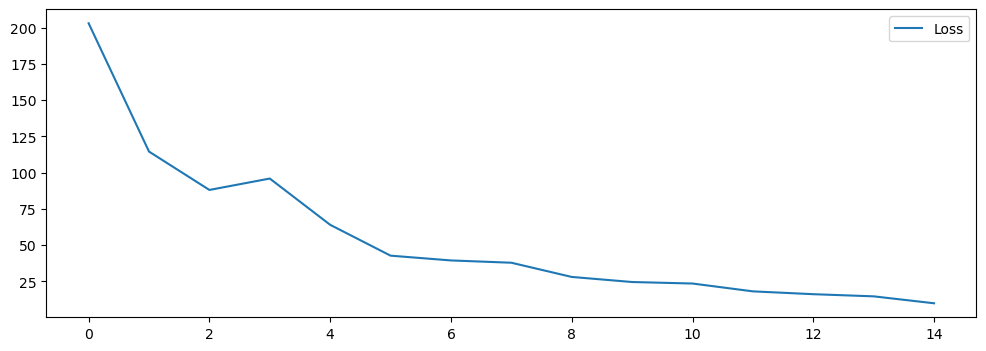

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"], label="Loss")
plt.legend()

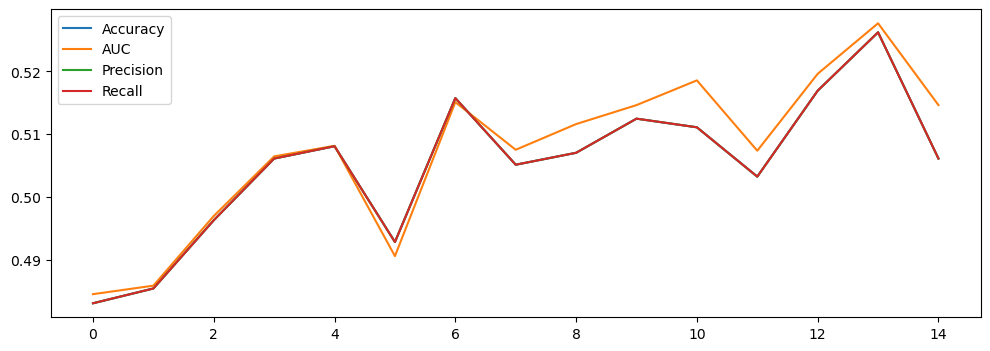

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["auc"], label="AUC")
plt.plot(history.history["precision"], label="Precision")
plt.plot(history.history["recall"], label="Recall")
plt.legend()

In [ ]:
history